# Tutorial - Extract

## Table of contents
1. [What is an Extract?](#whatis)
2. [How to create an Extract?](#howto)
    1. [Local backend](#howto_local)
    2. [S3 backend](#howto_s3)
3. [Tips & tricks](#tricks)

## 1. What is an Extract? <a name="whatis"></a>

Extract is a tool for migrating data between different databases.
<br>
The Extract tool can have different stores (where you store inputs such as the store and list of partitions to download) and data (where you store produced data) backends. There are currently two supported backends*: `S3` and `local`. By default, the Extract will use `local` backend and take inputs from current directory.
<br>
> As of grizly v0.3.9, only `S3` is supported for store and data backends.

## 2. How to create an Extract? <a name="howto"></a>

## 2.1 Local backend <a name="howto_local"></a>

### 2.1.1 Create the driver
>Typically, we will be loading it from a JSON file. Alternatively, it's also possible to load it directly from a table, as in below example. For more information, see the QFrame tutorial.

In [1]:
from grizly import QFrame
from pathlib import Path
import logging

# name of your logger
logger = logging.getLogger("distributed.worker").getChild("dss_extract")
sqlite_dsn = Path.cwd().parent.joinpath("tests", "Chinook.sqlite")

qf = QFrame(dsn=sqlite_dsn, db="sqlite", dialect="mysql").from_table(table="Track")
print(qf)

SELECT "TrackId",
       "Name",
       "AlbumId",
       "MediaTypeId",
       "GenreId",
       "Composer",
       "Milliseconds",
       "Bytes",
       "UnitPrice"
FROM Track


### 2.1.2 Create Extract store*
* See [Extract store documentation](#extract_store) for more information

The concept of partition columns is used because currently, extracts are used to extract data from Denodo, and Denodo only contains views on tables located in actual databases. In effect, Denodo views don't have identity columns by which we could trivially chunk data. 
<br><br>
There are several strategies for selecting an optimal partition column. The goal is to have data split into 2-300 (depending on the size of data) more or less equal parts. One good idea is to use GROUPBYs on columns that seem like good candidates (eg. years, months). Another method utilizing a pandas DataFrame is shown below.

1. Find columns with relatively few unique values

In [3]:
df = qf.to_df()
df.nunique()

TrackId         3503
Name            3257
AlbumId          347
MediaTypeId        5
GenreId           25
Composer         852
Milliseconds    3080
Bytes           3501
UnitPrice          2
dtype: int64

2. Check the distribution of values

In [4]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, http://acoe.connect.te.com


<AxesSubplot:>

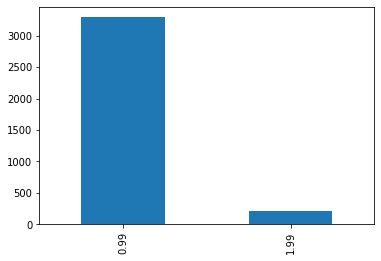

In [5]:
df.UnitPrice.value_counts().plot(kind="bar")

<AxesSubplot:>

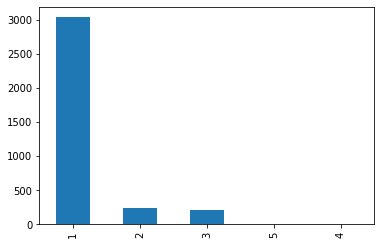

In [6]:
df.MediaTypeId.value_counts().plot(kind="bar")

<AxesSubplot:>

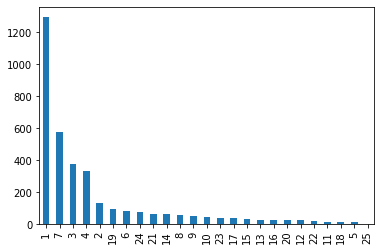

In [7]:
df.GenreId.value_counts().plot(kind="bar")        

It seems like the GenreId column has the most optimal distribution.

In [8]:
store = {
    "partition_cols": ["GenreId"],
    "output": {
        "oputput_dsn": f"{sqlite_dsn}"
    }
}

def dict_pprint(d):
    import json
    print(json.dumps(d, indent=4, sort_keys=True))
    
dict_pprint(store)

{
    "output": {
        "oputput_dsn": "/home/analyst/grizly_dev/tests/Chinook.sqlite"
    },
    "partition_cols": [
        "GenreId"
    ]
}


### 2.1.3 Run the Extract

In [ ]:
import os
from grizly import Extract

dask_scheduler = "dask_scheduler:8786"
extract_name = "Example Local Extract"
# here we're passing store directly, but you can also use json file: store_path="/home/usr/somewhere/store.json"
e = Extract(extract_name, qf, store=store, if_exists="replace")
e.submit(dask_scheduler)

## 2.2 S3 backend (recommended) <a name="howto_s3"></a>

### 2.2.1 Create a folder for assets in S3
We'll be storing all of the assets on S3, so go ahead and create a folder for your extract in s3. By default, with S3 backend, Extract will look for store in `s3://your_bucket/extracts/your_extract_name`. However you can modify this behavior by specifying the `store_path` parameter, eg. to 
```python
f"s3://{my_bucket}/my/path/my_store.json"
```

Creating QFrame's store is covered in the  QFrame tutorial. Below code is just for the sake of the tutorial.

In [ ]:
from grizly import S3, config

bucket = config.get_service("s3").get("bucket")
qf_store_path = f"s3://{bucket}/extracts/example_extract/example_qf_store.json"
qf_store_dict = qf.store.to_dict(subquery="example_subquery")
S3(url=qf_store_path).from_serializable(qf_store_dict)

### 2.2.2 Prepare the driver
In this example we'll be using a QFrame:

In [ ]:
from grizly import QFrame, config
import logging

# name of your logger
logger = logging.getLogger("distributed.worker").getChild("example_s3_extract")

# load the driver
bucket = config.get_service("s3").get("bucket")
qf_store_path = f"s3://{bucket}/extracts/example_extract/example_qf_store.json"
qf = QFrame(dsn=sqlite_dsn, db="sqlite", dialect="mysql", logger=logger).from_json(qf_store_path, subquery="example_subquery")

### 2.2.3 Prepare Extract store

In [ ]:
store

## 3. Tips & tricks

### 3.1 Utilizing `if_exists="append"`

The `append` parameter allows us to load only the new partitions. For example, if we are loading a table that refreshes weekly, we can provide a set of partition columns that include a week columns, eg.
```json
{
  partitions_list: ["other_col", "week_no"]
}
```
This way, whenever an Extract with the `append` option is re-run, it will not re-download the parts for existing weeks.

## Extract store in depth <a name="extract_store"></a>